In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [128]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import pycbcwaveform as pycbcwave
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(pycbcwave)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Code for making training set

In [3]:
def bns_merger_frequency(smallq, lambda1, lambda2):
    """lambda1 is for the more massive star.
    lambda2 is for the less massive star.
    smallq = m2/m1.
    This is the opposite notation as used in the Bernuzzi tidal EOB papers.
    This fit breaks down when q is significantly different from q=1.
    (q=0.5 is fine but the q=0 limit does not return the Schwarzschild ISCO limit.)
    Also probably not valid for lambda1 = lambda2 > 5000.
    """

    kappa = 3.0*( smallq*(1/(1+smallq))**5*lambda1 + smallq*(smallq/(1+smallq))**5*lambda2 )
    
    f0 = 0.360
    n1, n2, d1 = 2.59e-2, -1.28e-5, 7.49e-2
    momega22 = f0 * (1 + n1*kappa + n2*kappa**2) / (1.0 + d1*kappa)
    
    return momega22 / (2.0*np.pi)

In [4]:
###########################################################
## One thing you you could do to accurately unwrap the phase without
## insanely high sampling frequency, is fit out a linear piece 
## (possibly with known chirp term) to the scattered wrapped phase. 
## Then, unwrap the phase and add the linear fit back.
###########################################################

# Make validation and training sets

In [5]:
# These parameters work for ISCO frequency:
mf_lower = 0.0008
delta_tbym = 10.0

tbym_tot = 3.0e6
mfon_end = 0.001
mfoff_start = 0.015
mfoff_end = 0.020
mftrunc_start = mfon_end

href_delta_mf = 5.0e-7

ndownsample = 1000

mffit_start = 0.001
mffit_end = 0.0012

In [362]:
# Parameters for the training set
Ndata = 512
limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
p_sub = gpr.latin_hypercube(Ndata, limits)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_training_set.hdf5'

trainset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')

trainset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [363]:
# Generate the validation set
q = 0.6
spin2z = 0.3
lambda1 = 2000.0
lambda2 = 1000.0
s1zs = np.linspace(-0.4, 0.4, 51)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2] for s1z in s1zs])

filename = '../data/aligned_validation_set.hdf5'

validset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
validset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [364]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
p_sub = gpr.uniform_random_samples(Ndata, limits)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_rand_set.hdf5'

randset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
randset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Now open WaveformSets and use them

In [6]:
trainset = ws.HDF5WaveformSet('../data/aligned_training_set.hdf5')
validset = ws.HDF5WaveformSet('../data/aligned_validation_set.hdf5')
randset = ws.HDF5WaveformSet('../data/aligned_rand_set.hdf5')

(0.0001, 0.1)

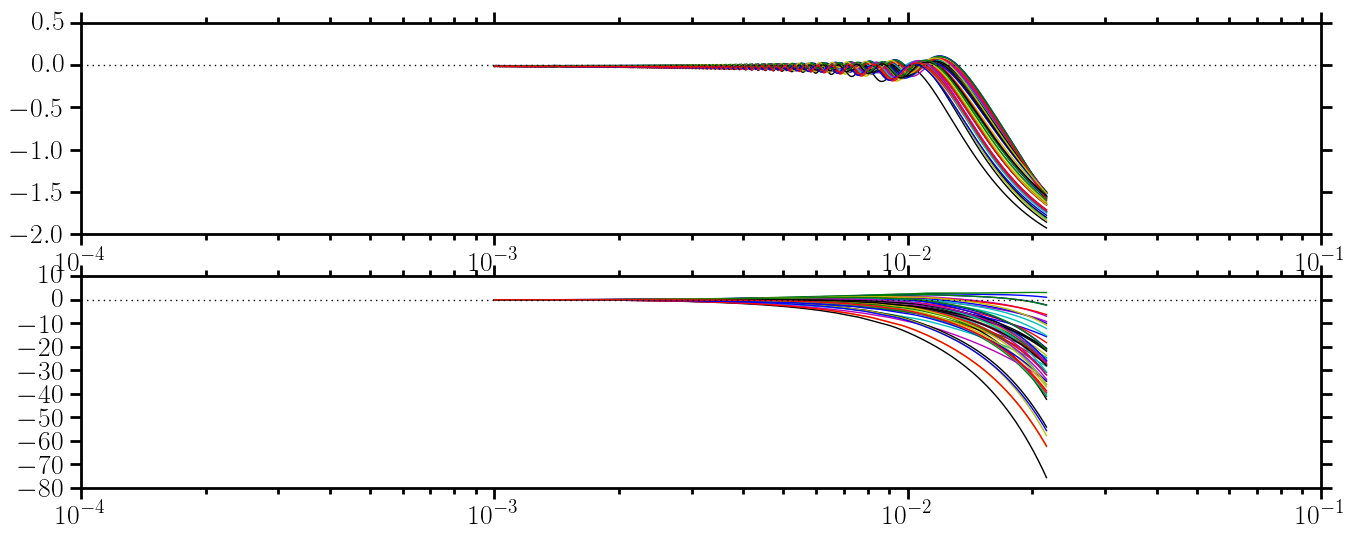

In [7]:
hs = [trainset[i] for i in range(0, len(trainset), 10)]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

(0.0001, 0.1)

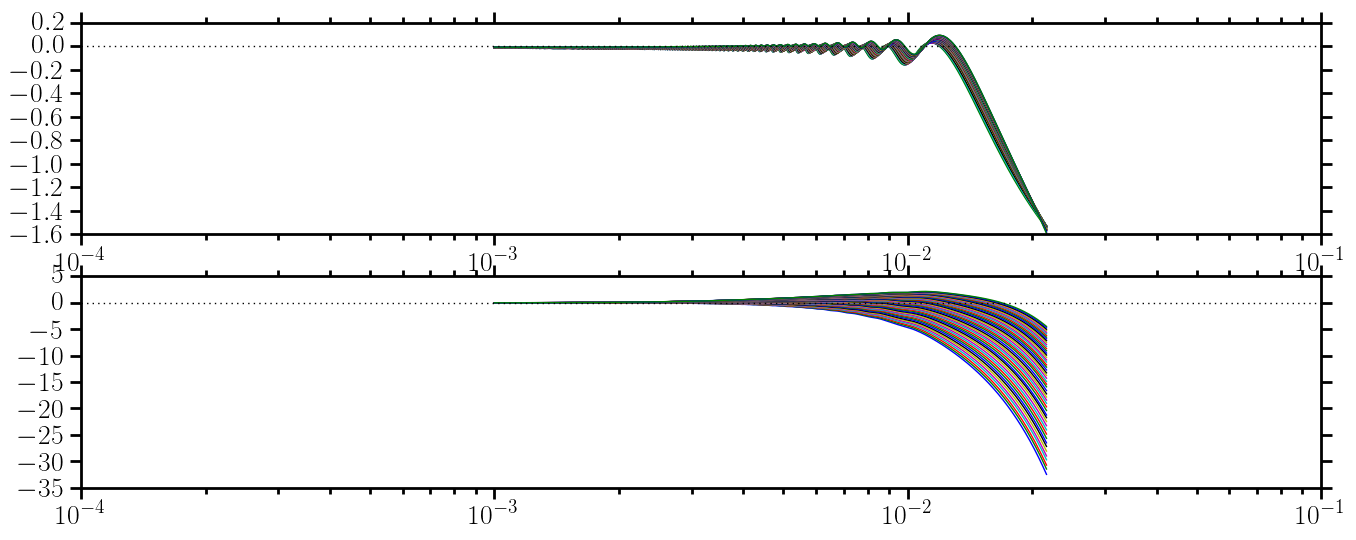

In [8]:
hs = [validset[i] for i in range(len(validset))]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

(0.0001, 0.1)

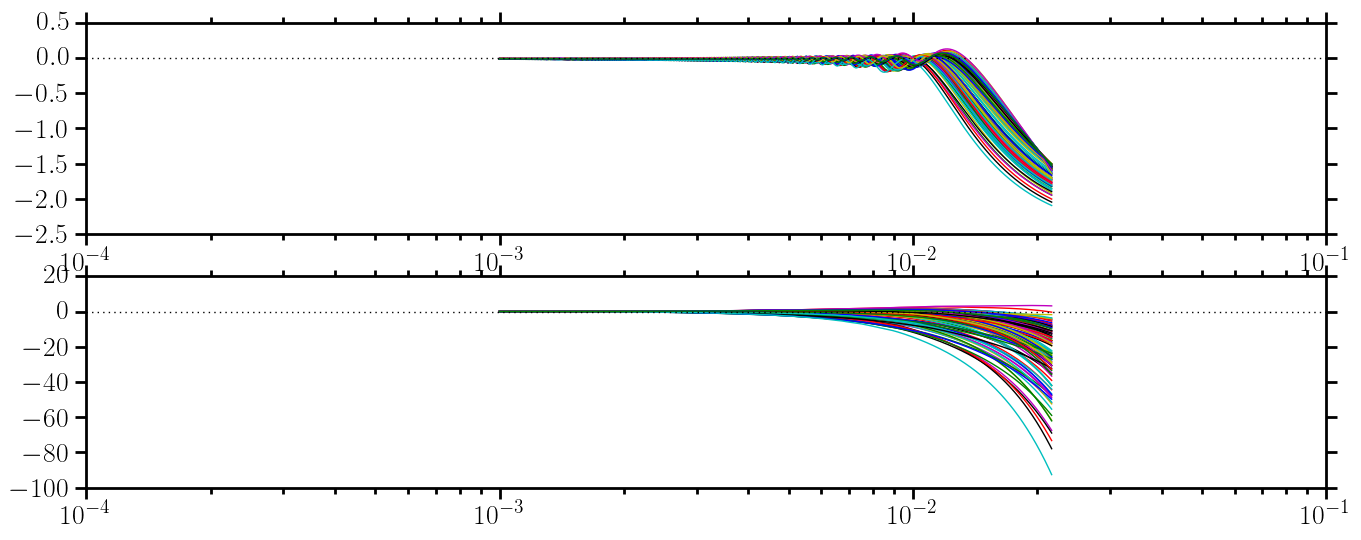

In [9]:
hs = [randset[i] for i in range(0, len(randset), 10)]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

0.013 942.618130615


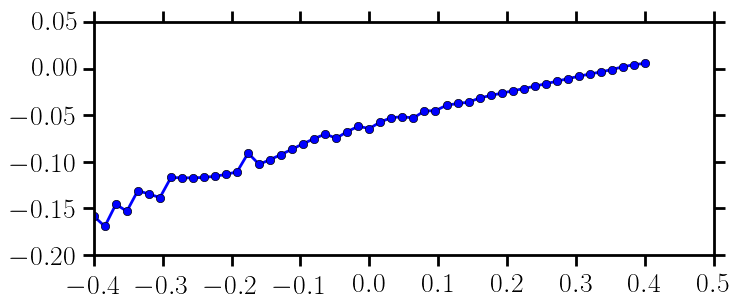

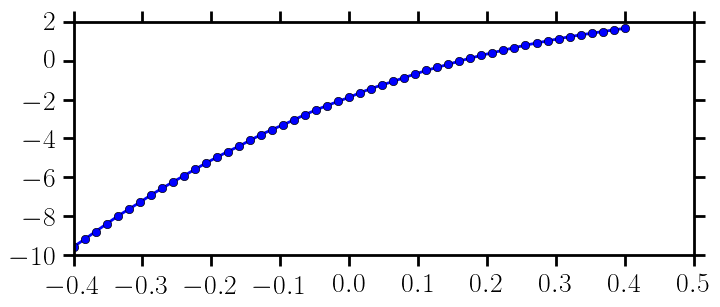

In [10]:
mf = 0.013
print mf, mf_to_f(mf, 2.8)

amps = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)


phis = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    phi = h.interpolate('phase')(mf)
    ps.append(p)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phis, 'o', ls='-', lw=2)

# Generate reduced Bases for amplitude and phase

In [11]:
epsilon = 1.0e-6

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.152601074645
0.00557559692131
0.00350680850457
0.00268652576656
0.00161038244848
0.000868979519408
0.000306180452935
0.000274129547324
0.000228080007478
0.000197238899538
0.000174497187302
0.000158151625748
9.4069201206e-05
7.36914793926e-05
6.66164285847e-05
4.93742007873e-05
4.75904059102e-05
3.83656410387e-05
3.19721040665e-05
2.58311649127e-05
1.84010710806e-05
1.59872767839e-05
1.57946128887e-05
1.3886414863e-05
1.21816540994e-05
1.17872514488e-05
8.49463652774e-06
8.11299561565e-06
7.43153250671e-06
6.45174658731e-06
5.37068281947e-06
4.76370654223e-06
4.29839922778e-06
4.0341851989e-06
3.93589638958e-06
3.53525709562e-06
3.16996977701e-06
2.91422991594e-06
2.90934020475e-06
2.74788856336e-06
2.43275986567e-06
2.23846239789e-06
2.21112399879e-06
1.89257437833e-06
1.64673013481e-06
1.46716628413e-06
1.4250435787e-06
1.2241961016e-06
1.21678041587e-06
1.12662494756e-06
1.0903851051e-06
1.07690219342e-06
1.01353413784e-06
9.77665355895e-07


In [12]:
len(rbamprun.rb)

55

(0.0001, 0.1)

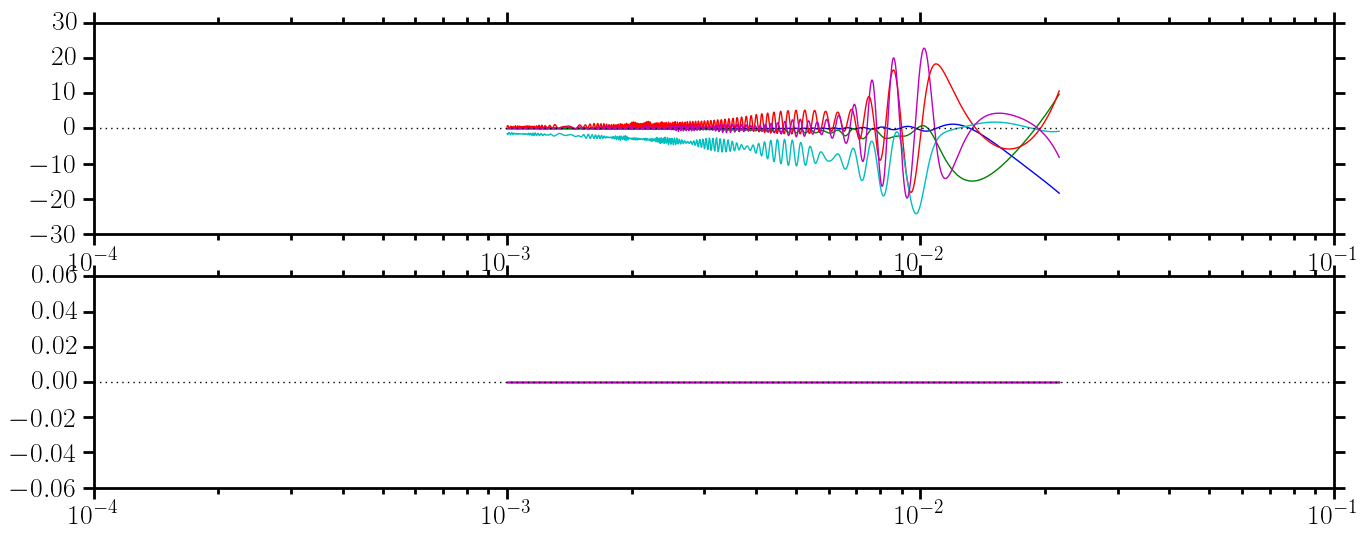

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, rbamprun.rb[:5])
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

In [15]:
epsilon = 1.0e-6

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.999940257501
0.0374426823199
0.000608794733753
0.000261917145289
4.98078036337e-05
2.10097726026e-05
1.58317573266e-05
1.02178842364e-05
5.70899555419e-06
2.84842162457e-06
2.44789074599e-06
2.19201578655e-06
1.39339344718e-06
1.32495963412e-06
8.12099608893e-07


In [16]:
len(rbphaserun.rb)

16

(0.0001, 0.1)

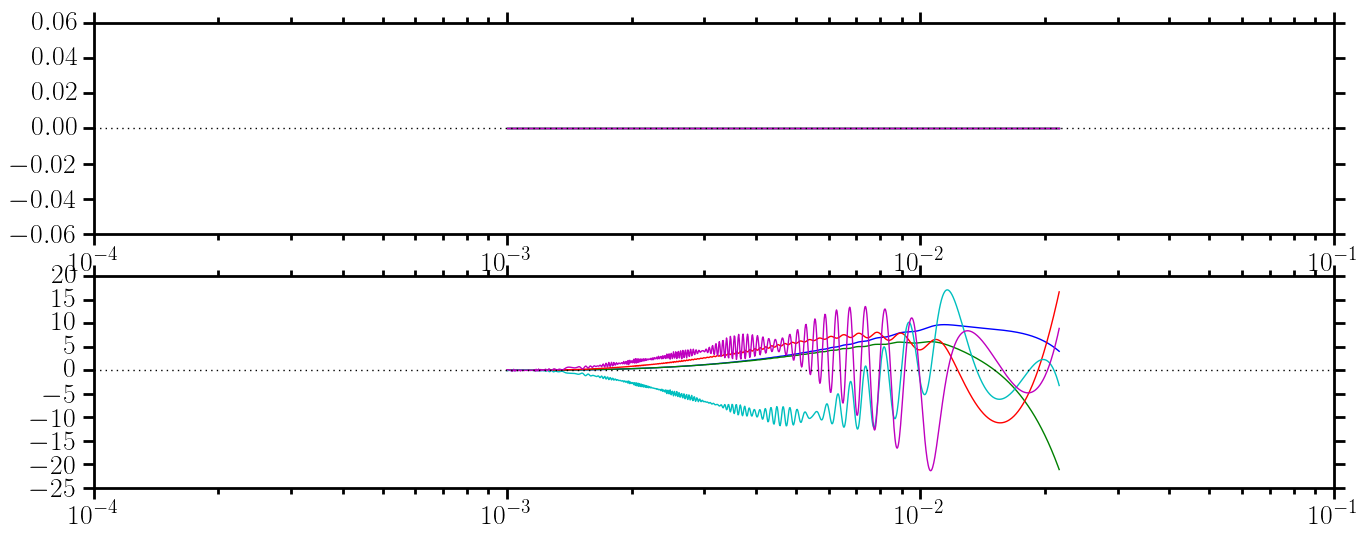

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, rbphaserun.rb[:5])
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

# Generate Empirical interpolating functions

In [20]:
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(rbamprun.rb[:10], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(rbphaserun.rb[:10], 'phase')

In [21]:
x_amp = Bamp_j[0].x[empirical_node_indices_amp]
x_phase = Bphase_j[0].x[empirical_node_indices_phase]

x_amp, x_phase

(array([ 0.021658  ,  0.01390262,  0.01100242,  0.0096978 ,  0.01025034,
         0.00762765,  0.00706263,  0.00567601,  0.00903489,  0.00590776]),
 array([ 0.01141646,  0.021658  ,  0.01616619,  0.00772215,  0.00674392,
         0.01028194,  0.00946188,  0.00640006,  0.00903489,  0.00494174]))

(0.0001, 0.1)

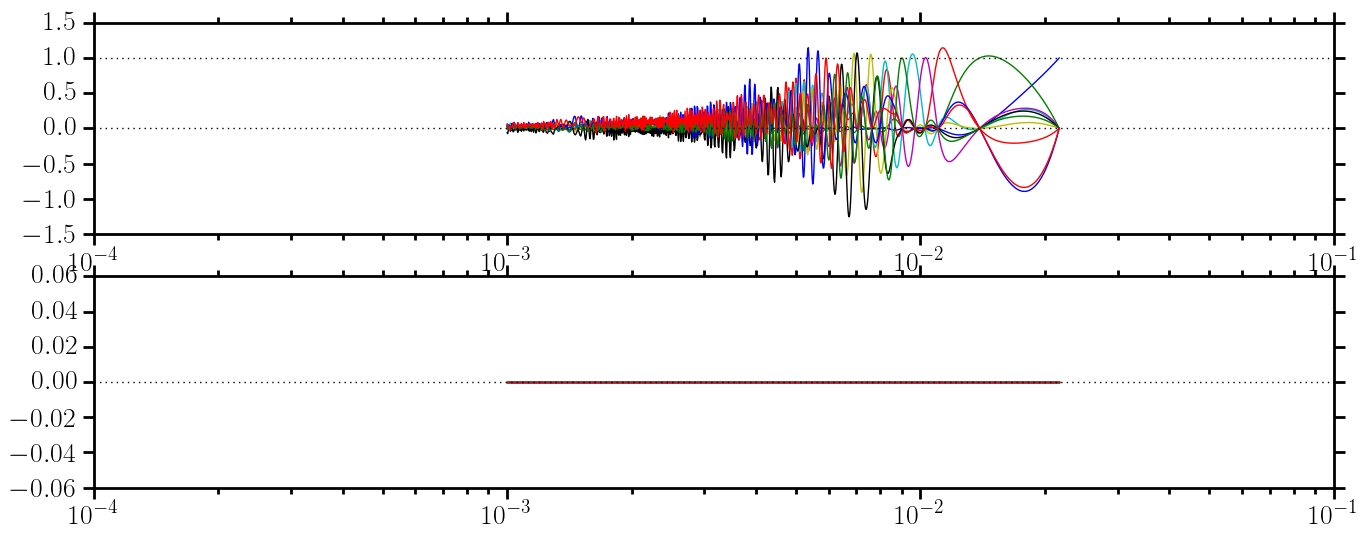

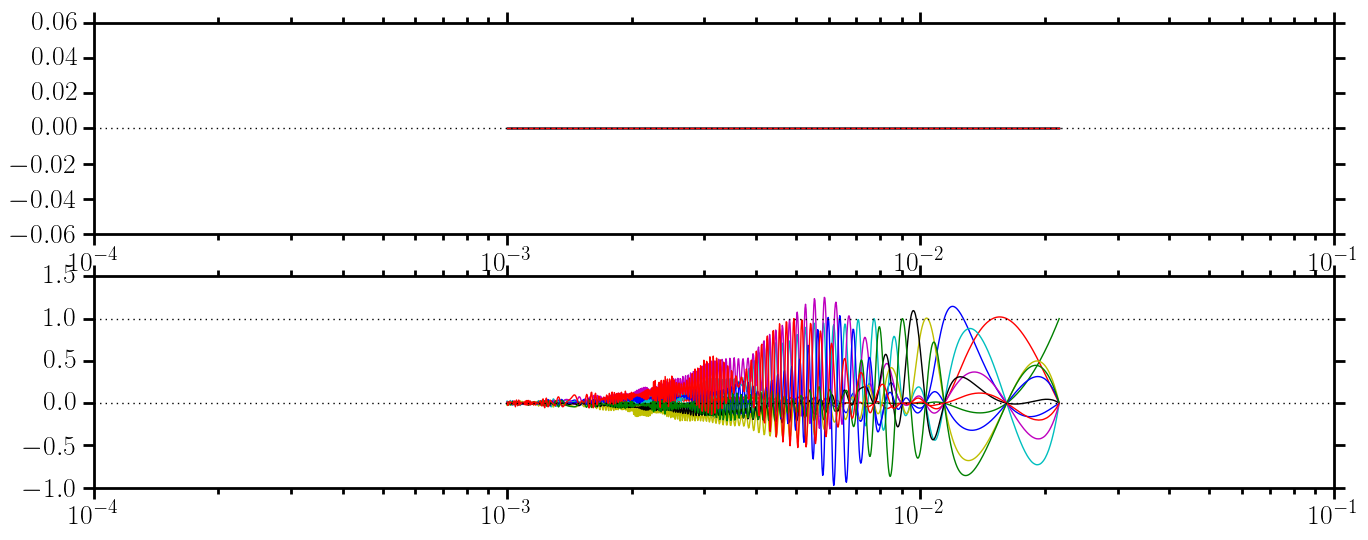

In [22]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, Bamp_j)
ax1.axhline(0, ls=':', c='k', lw=1)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, Bphase_j)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(1, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

# Generate Gaussian processes

In [23]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(x_amp)):
    mf = x_amp[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(x_phase)):
    mf = x_phase[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()[:, [0, 3, 6, 7, 8]]

In [24]:
# Generate list of damp GPs at each frequency in mfs
hp0 = np.array([0.5, 0.5, 0.4, 0.4, 5000.0, 5000.0, 0.1])
limits = np.array([[0.01, 100], [0.1, 100], [0.1, 100], [0.1, 100], [100, 50000], [100, 50000], [0.00001, 1.0]])

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i,
    damp_gp = gpr.generate_square_exponential_gp(params_ts, damp_ts_list[i], hp0, limits, n_restarts_optimizer=9)
    damp_gp_list.append(damp_gp)

0 1 2 3 4 5 6 7 8 9


In [25]:
# Generate list of dphase GPs at each frequency in mfs
hp0 = np.array([5.0, 0.5, 0.4, 0.4, 5000.0, 5000.0, 0.1])
limits = np.array([[0.0001, 500], [0.1, 100], [0.1, 100], [0.1, 100], [100, 100000], [100, 100000], [0.00001, 1.0]])

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i,
    dphase_gp = gpr.generate_square_exponential_gp(params_ts, dphase_ts_list[i], hp0, limits, n_restarts_optimizer=9)
    dphase_gp_list.append(dphase_gp)

0

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.15792097e-04,  -4.76536254e-04,   1.00728001e-04,
         1.77473412e-05,   7.39738143e-04,  -8.38551391e+00,
         2.33527318e-04]), 'nit': 20, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.82091258e-03,   2.63816873e-03,  -1.46382194e-02,
         7.54347879e-03,   1.87456184e-02,  -8.38492731e+00,
         1.14937904e-02]), 'nit': 26, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated 

 1

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.54248512e+00,  -1.67538995e-03,  -3.04755462e-03,
        -7.00441516e-03,   2.47587692e-03,  -1.01364384e+01,
         2.14051776e-03]), 'nit': 21, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.54162136e+00,   3.66249687e-03,  -7.82759174e-03,
        -1.11493073e-02,   1.74873629e-03,  -1.01360029e+01,
         5.70496556e-03]), 'nit': 25, 'funcalls': 82}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated 

 2

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.91807237e-04,  -6.01113499e-03,   8.46409517e-03,
        -8.55497274e-04,   8.34614510e-04,  -1.24405617e+01,
        -4.70719382e-03]), 'nit': 28, 'funcalls': 112}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.71309337e-04,  -5.87874626e-03,   9.24599220e-04,
         2.01369689e-03,  -2.40708449e-04,  -1.24403521e+01,
         3.94761388e-03]), 'nit': 25, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated

 3 4 5

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00326683,  0.00036906, -0.00593021, -0.00194924, -0.00467092,
        0.01334443, -0.00361093]), 'nit': 27, 'funcalls': 89}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00203261,  0.01788649,  0.00415715,  0.0042736 , -0.00794386,
       -0.00942321, -0.0146717 ]), 'nit': 19, 'funcalls': 66}
  " state: %s" % convergence_dict)


 6

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00274985, -0.00921767, -0.00516957, -0.0033828 ,  0.00056465,
       -0.00015812, -0.00223921]), 'nit': 26, 'funcalls': 79}
  " state: %s" % convergence_dict)
/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00139902, -0.00549971,  0.01022005,  0.00724662,  0.00961628,
       -0.00355122, -0.00798847]), 'nit': 25, 'funcalls': 78}
  " state: %s" % convergence_dict)


 7 8 9


0.0102503385678


(0, 1.1)

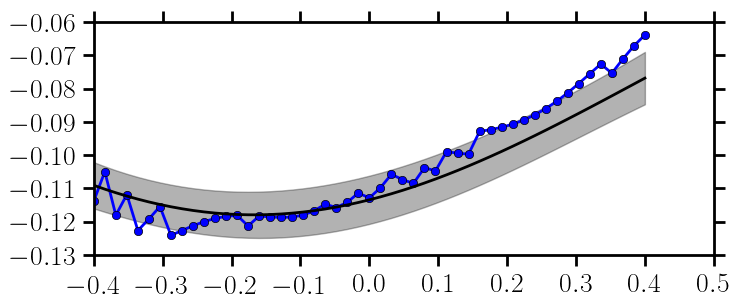

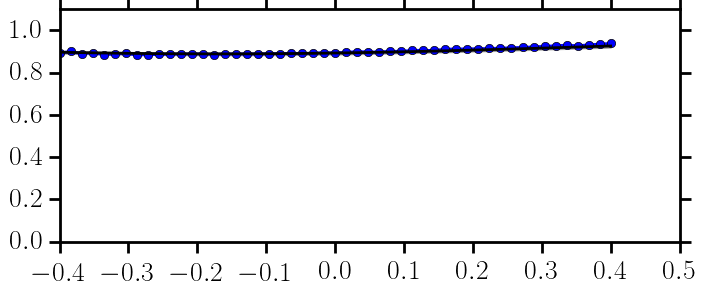

In [28]:
i = 4
mf = x_amp[i]
print mf

params_vs = validset.parameters()[:, [0, 3, 6, 7, 8]]

damp_vs = np.array([validset[j].interpolate('amp')(mf) for j in range(len(validset))])
damp_gp = damp_gp_list[i]
damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_vs, return_std=True)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], damp_vs, 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], damp_gp_eval, ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, color='k', alpha=0.3)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], np.exp(damp_vs), 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], np.exp(damp_gp_eval), ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], np.exp(damp_gp_eval-damp_gp_eval_err), np.exp(damp_gp_eval+damp_gp_eval_err), color='k', alpha=0.3)
axes.set_ylim(0, 1.1)

0.00674391812246


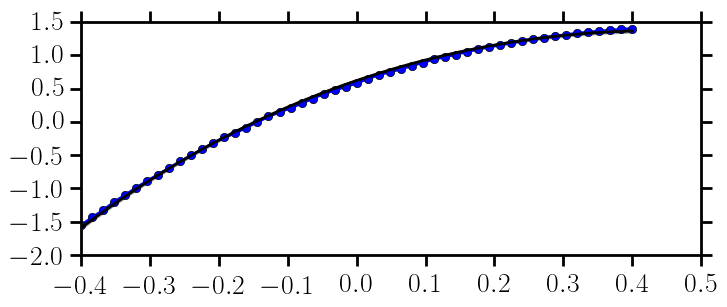

In [29]:
i = 4
mf = x_phase[i]
print mf

dphase_vs = np.array([validset[j].interpolate('phase')(mf) for j in range(len(validset))])
dphase_gp = dphase_gp_list[i]
dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_vs, return_std=True)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], dphase_vs, 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], dphase_gp_eval, ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, color='k', alpha=0.3)

In [30]:
def fractional_amp_error(dlnamp_sur, dlnamp_true):
    """Calculate A_sur/A_true-1 given dlnA_sur and dlnA_true,
    where dlnA_sur = lnA_sur-lnA_ref and dlnA_true = lnA_true-lnA_ref.
    """
    error = np.exp(dlnamp_sur-dlnamp_true)-1.0
    return np.max(np.abs(error))

def phase_error(dphase_sur, dphase_true):
    """Calculate Phi_sur-Phi_true given dPhi_sur and dPhi_true,
    where dPhi_sur = Phi_sur-Phi_ref and Phi_true = Phi_true-Phi_ref.
    """
    error = dphase_sur-dphase_true
    return np.max(np.abs(error))

In [32]:
params_rand = []
amp_err = []
phase_err = []
for i in range(len(randset)):
    hrand = randset[i]
    params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
    hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)
    ae = fractional_amp_error(hsur.amp, hrand.amp)
    pe = phase_error(hsur.phase, hrand.phase)
    params_rand.append(params)
    amp_err.append(ae)
    phase_err.append(pe)

In [33]:
np.max(amp_err), np.max(phase_err)

(0.098849481392456306, 0.57433380654492794)

In [34]:
i_ampmax = np.array(amp_err).argmax()
i_phasemax = np.array(phase_err).argmax()

In [35]:
params_rand[i_ampmax], params_rand[i_phasemax]

(array([  6.05034112e-01,  -3.39101954e-01,  -3.67510859e-01,
          4.98053851e+03,   4.46995979e+03]),
 array([  5.00707937e-01,  -3.43897367e-01,   3.49956057e-01,
          4.87214051e+03,   4.92568631e+02]))

[  6.05034112e-01  -3.39101954e-01  -3.67510859e-01   4.98053851e+03
   4.46995979e+03]


(0.0001, 0.1)

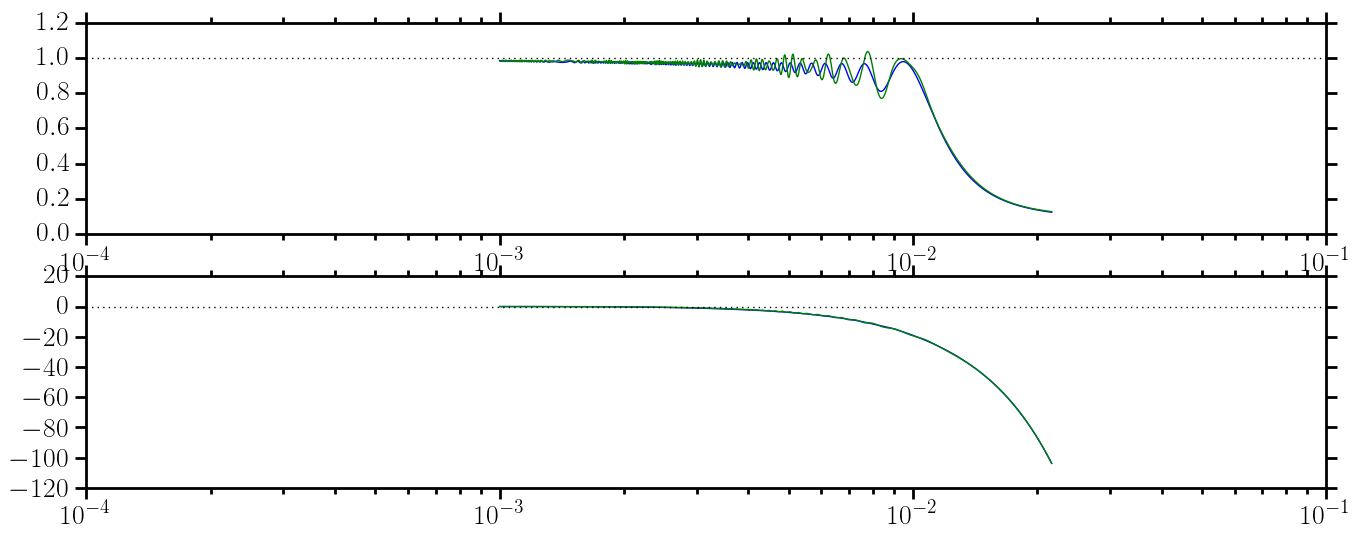

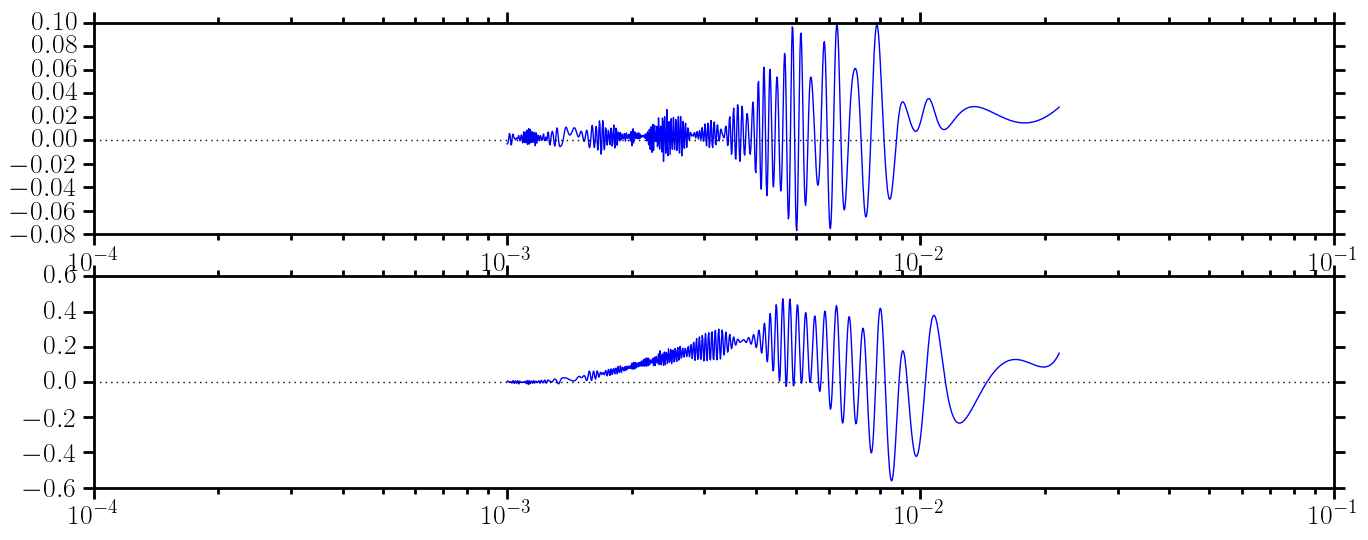

In [36]:
i = i_ampmax
hrand = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, [hrand, hsur], exp=True)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

ae = np.exp(hsur.amp-hrand.amp)-1.0
pe = hsur.phase-hrand.phase
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(hsur.x, ae)
ax2.plot(hsur.x, pe)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

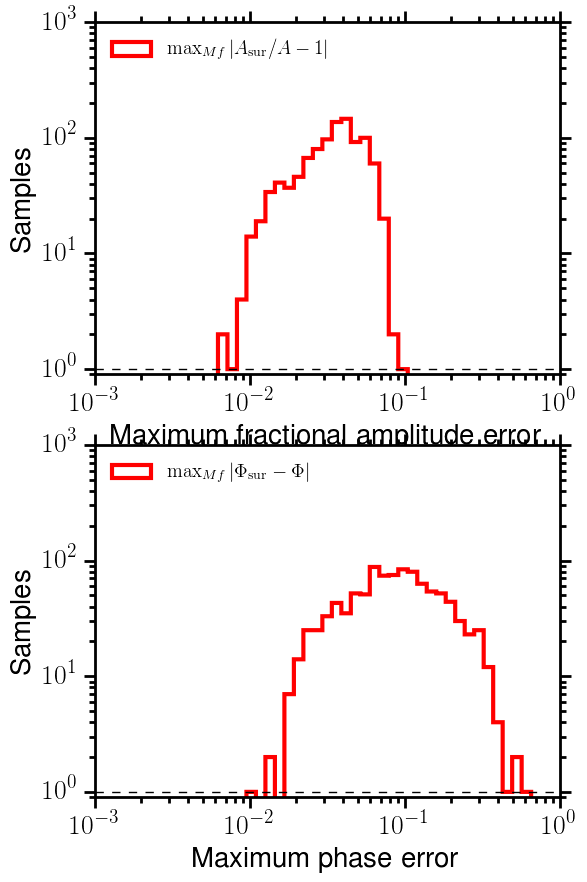

In [37]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

ax1.hist(amp_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 1.0])
ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)

ax2.hist(phase_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 1.0])
ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)

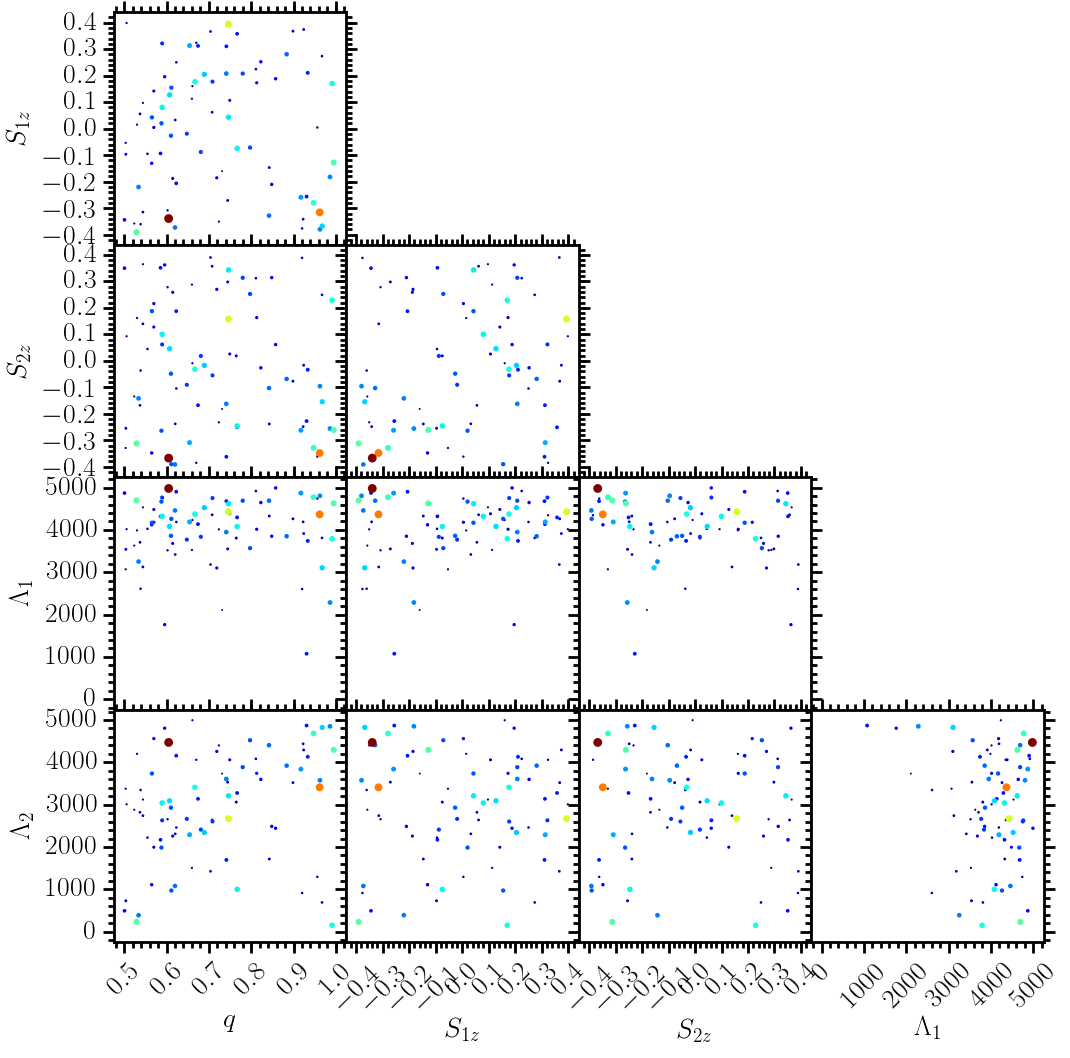

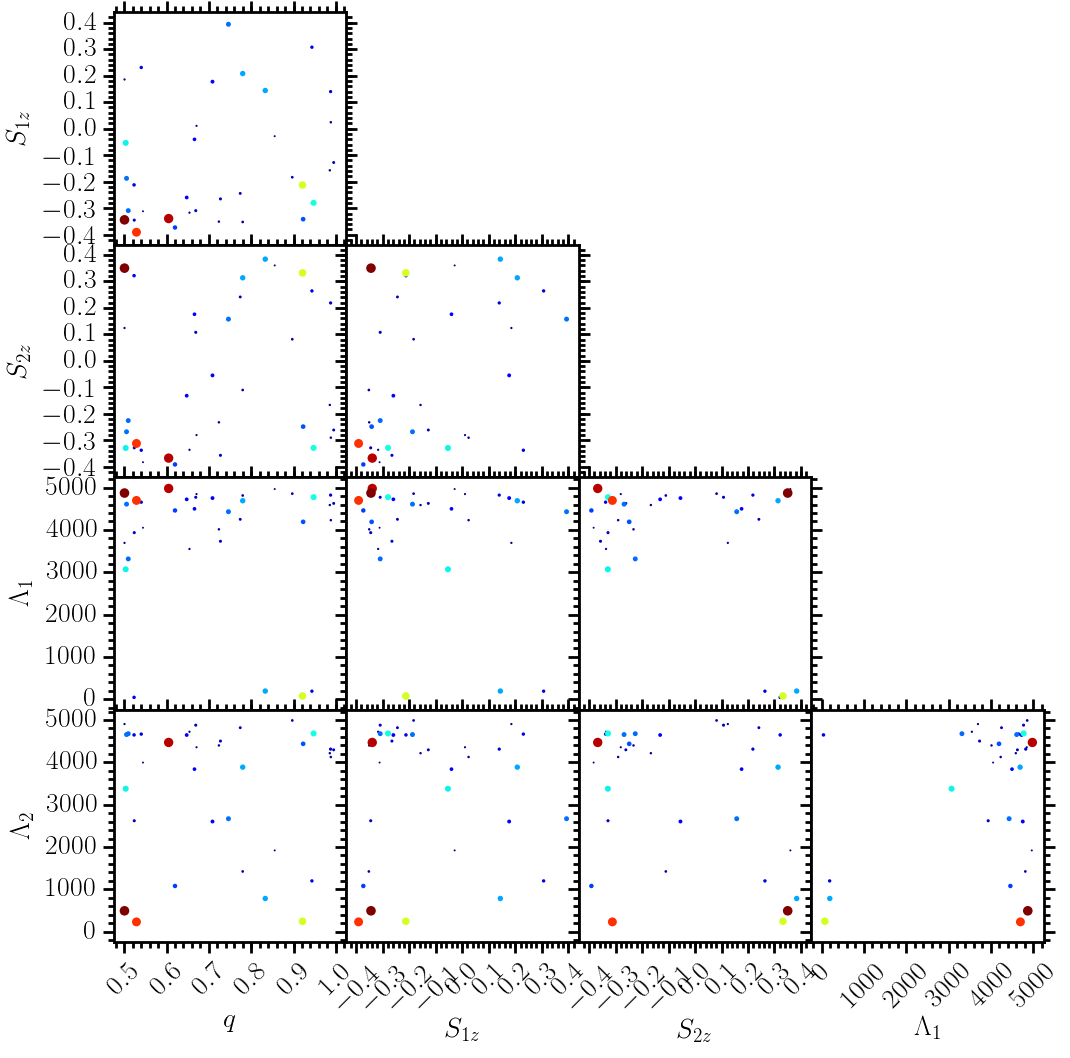

In [135]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_rand

error = amp_err
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.06, figsize=(10, 10))

error = phase_err
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.3, figsize=(10, 10))

# Old results

In [68]:
def reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list):
    """
    """
    params_2d = np.atleast_2d(params)
    damp = []
    damp_err = []
    dphase = []
    dphase_err = []
    for i in range(len(mfs)):
        damp_gp = damp_gp_list[i]
        dphase_gp = dphase_gp_list[i]
        
        damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_2d, return_std=True)
        dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_2d, return_std=True)
        
        damp.append(damp_gp_eval[0])
        damp_err.append(damp_gp_eval_err[0])
        dphase.append(dphase_gp_eval[0])
        dphase_err.append(dphase_gp_eval_err[0])
    
    dh = wave.Waveform.from_amp_phase(np.array(mfs), np.array(damp), np.array(dphase))
    dh_err = wave.Waveform.from_amp_phase(np.array(mfs), np.array(damp_err), np.array(dphase_err))
    return dh, dh_err

In [69]:
def plot_waveforms_fd_comparison(ax1, ax2, htrue, hgp, hgp_err, exp=False):
    """
    """
    htrue_c = htrue.copy()
    hgp_c = hgp.copy()
    hgp_err_c = hgp_err.copy()
    wave.resample_uniform(htrue_c, spacing='log', order=2)
    wave.resample_uniform(hgp_c, spacing='log', order=2)
    wave.resample_uniform(hgp_err_c, spacing='log', order=2)

    if exp==False:
        ax1.plot(htrue_c.x, htrue.amp)
        ax1.plot(hgp_c.x, hgp_c.amp)
        ax1.plot(hgp.x, hgp.amp, 'o')
        ax1.fill_between(hgp_err_c.x, hgp_c.amp-hgp_err_c.amp, hgp_c.amp+hgp_err_c.amp, 
                         color='k', alpha=0.3)
    else:
        ax1.plot(htrue_c.x, np.exp(htrue.amp))
        ax1.plot(hgp_c.x, np.exp(hgp_c.amp))
        ax1.plot(hgp.x, np.exp(hgp.amp), 'o')
        ax1.fill_between(hgp_err_c.x, np.exp(hgp_c.amp-hgp_err_c.amp), np.exp(hgp_c.amp+hgp_err_c.amp), 
                         color='k', alpha=0.3)
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
        
    ax2.plot(htrue_c.x, htrue.phase)
    ax2.plot(hgp_c.x, hgp_c.phase)
    ax2.plot(hgp.x, hgp.phase, 'o')
    ax2.fill_between(hgp_err_c.x, hgp_c.phase-hgp_err_c.phase, hgp_c.phase+hgp_err_c.phase, 
                     color='k', alpha=0.3)
    ax2.set_xscale('log')

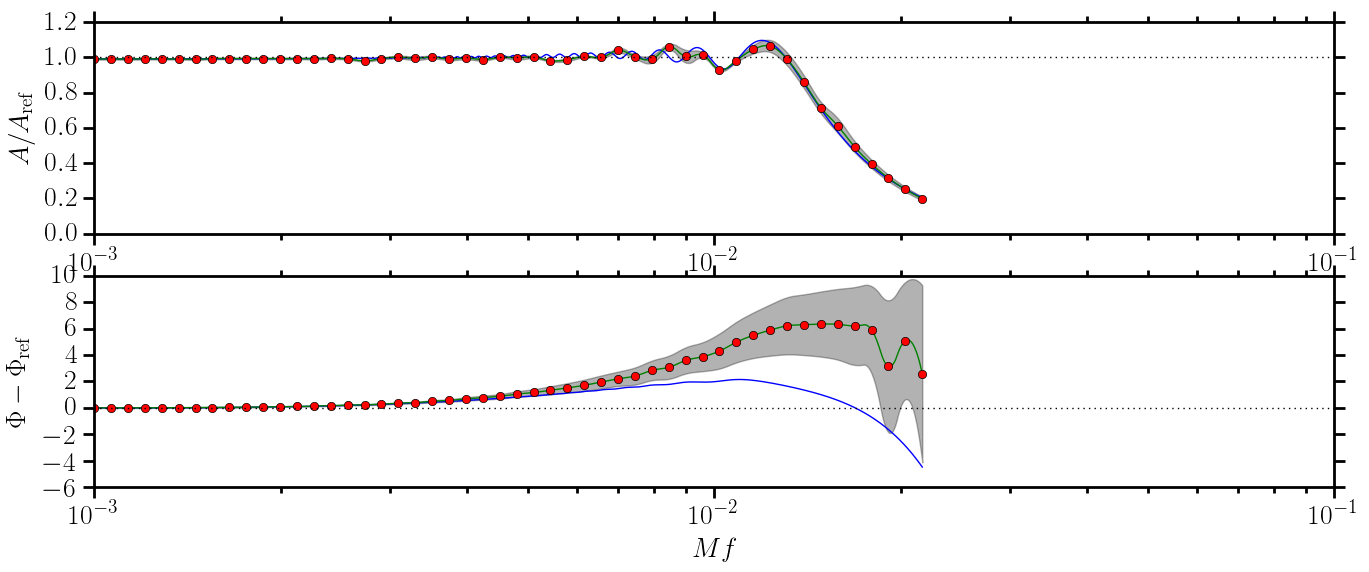

In [70]:
i = 10
hv = validset[i]
params = validset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
plot_waveforms_fd_comparison(ax1, ax2, hv, dh, dh_err, exp=True)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
# ax1.set_ylabel(r'$\ln(A/A_{\rm ref})$')
ax1.set_ylabel(r'$A/A_{\rm ref}$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm ref}$')
ax2.set_xlabel(r'$Mf$')

[  7.24617989e-01  -3.61746945e-01  -1.42137429e-01   2.77147141e+03
   1.18658072e+03]


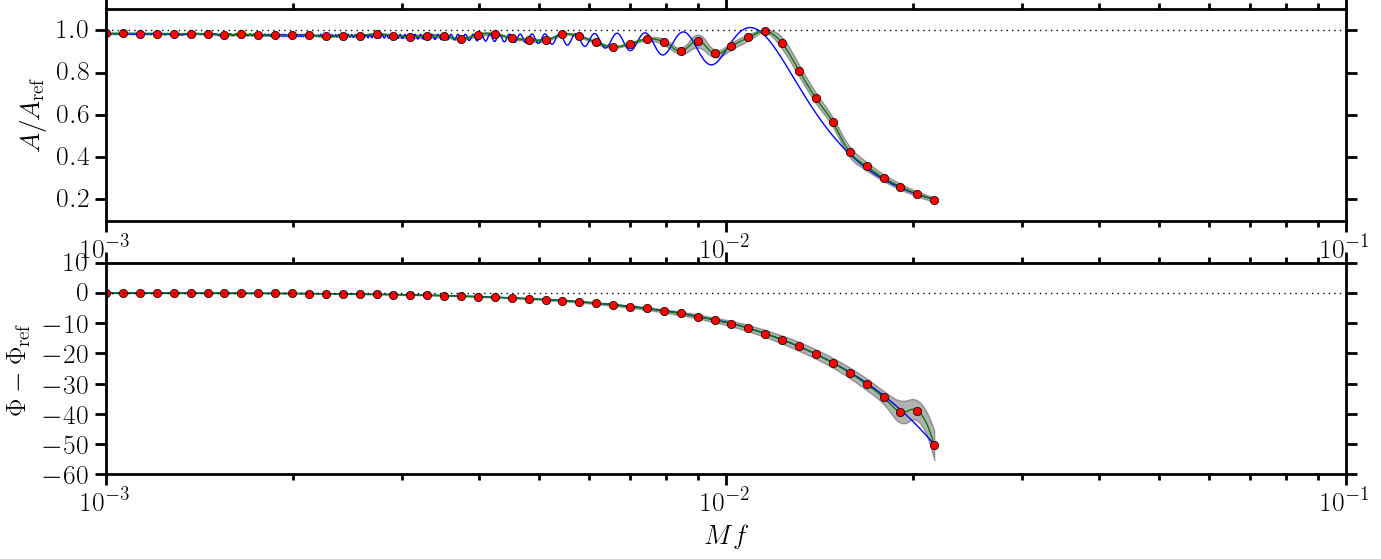

In [71]:
i = 9
hv = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
plot_waveforms_fd_comparison(ax1, ax2, hv, dh, dh_err, exp=True)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
# ax1.set_ylabel(r'$\ln(A/A_{\rm ref})$')
ax1.set_ylabel(r'$A/A_{\rm ref}$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm ref}$')
ax2.set_xlabel(r'$Mf$')

In [72]:
i = 0
hv = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

amp_err_at_nodes = np.exp(dh.amp-hv.interpolate('amp')(mfs))-1
phase_err_at_nodes = dh.phase-hv.interpolate('phase')(mfs)

amp_err = np.exp(dh.interpolate('amp')(hv.x)-hv.interpolate('amp')(hv.x))-1
phase_err = dh.interpolate('phase')(hv.x)-hv.interpolate('phase')(hv.x)

[  5.27472185e-01   1.46143054e-01   1.60476142e-01   2.83247302e+03
   6.79496853e+02]


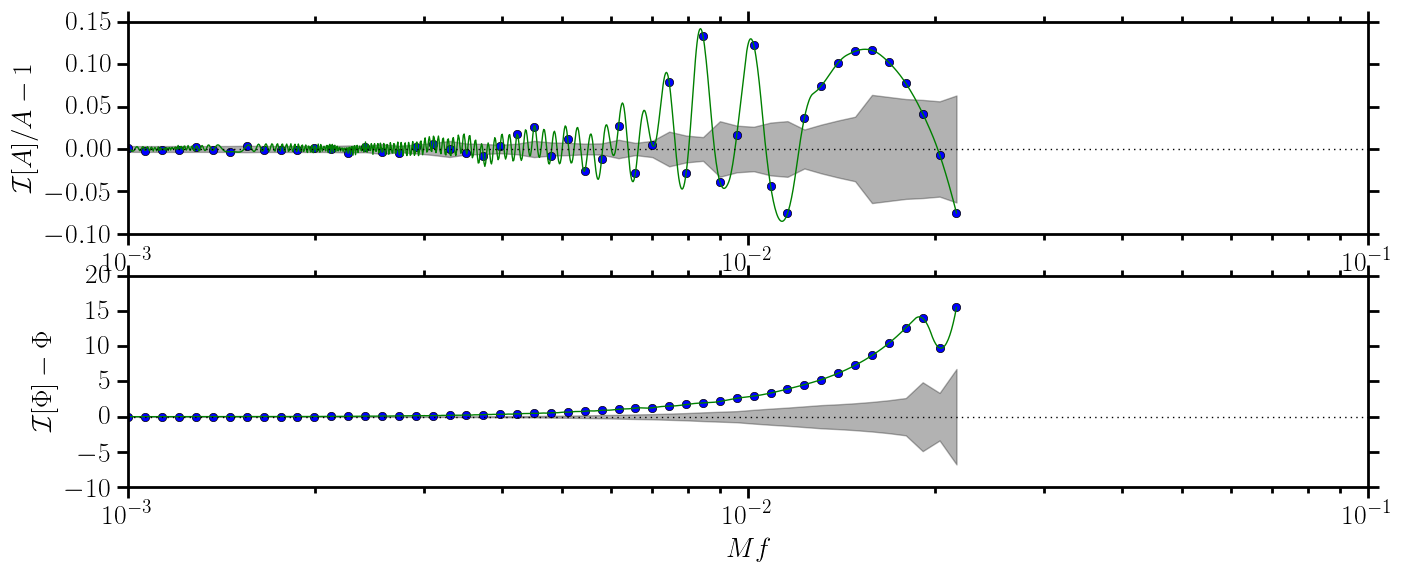

In [73]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(mfs, amp_err_at_nodes, 'o')
ax1.fill_between(dh_err.x, -dh_err.amp, dh_err.amp, color='k', alpha=0.3)
ax1.plot(hv.x, amp_err)

ax2.plot(mfs, phase_err_at_nodes, 'o')
ax2.fill_between(dh_err.x, -dh_err.phase, dh_err.phase, color='k', alpha=0.3)
ax2.plot(hv.x, phase_err)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_ylabel(r'$\mathcal{I}[A]/A-1$')
ax2.set_ylabel(r'$\mathcal{I}[\Phi]-\Phi$')
ax2.set_xlabel(r'$Mf$')

# Old plots which may come in handy

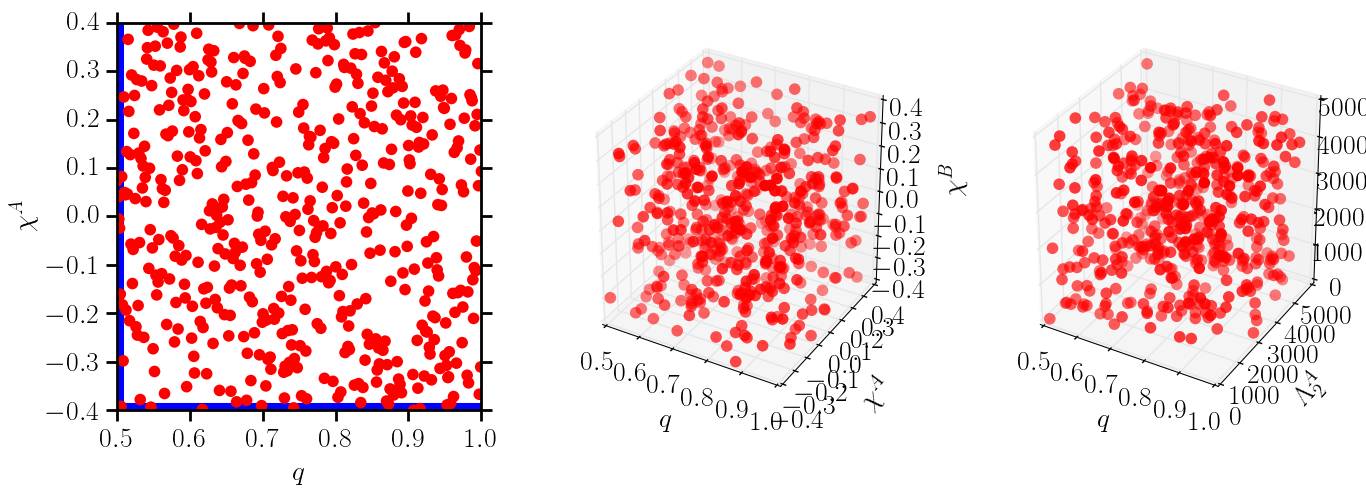

In [41]:
points = params

# ******* plot data *******
fig = plt.figure(figsize=(16, 5))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(131)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\chi^A$')
#axes.set_ylabel(r'$\Lambda_2^A$')


# ****** Full 3d data ******
axes = fig.add_subplot(132, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$\chi^A$', labelpad=15)
axes.set_zlabel(r'$\chi^B$', labelpad=18)
# axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
# axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

axes = fig.add_subplot(133, projection='3d')

x, y, z = points[:, 0], points[:, 3], points[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[3])
axes.set_zlim(limits[4])
axes.set_xlabel(r'$q$', labelpad=10)
# axes.set_ylabel(r'$\chi_2^A$', labelpad=15)
# axes.set_zlabel(r'$\chi_2^B$', labelpad=18)
axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

In [123]:
def error_1d_projection(x, error, error_type='max', xmin=None, xmax=None, nbins=10):
    """
    """
    if xmin==None: xmin = x.min()
    if xmax==None: xmax = x.max()

    bin_edges = np.linspace(xmin, xmax, nbins+1)
    
    # Find which bin each data point is in
    bini = np.digitize(x, bin_edges)
    
    # Find the maximum error in each bin
    error_stat = []
    for i in range(1, len(bin_edges)):
        # errors from bin_edges[i-1] <= x <= bin_edges[i]
        errors_in_bin = error[bini==i]
        if len(errors_in_bin)==0:
            error_stat.append(0.0)
        else:
            if error_type=='max':
                error_stat.append(np.max(errors_in_bin))
            elif error_type=='mean':
                error_stat.append(np.mean(errors_in_bin))
        
    return bin_edges, np.array(error_stat)

In [124]:
def error_1d_projection_plot(axes, x, error, error_type='max', xmin=None, xmax=None, nbins=10, **kwargs):
    """
    """
    bin_edges, max_error = error_1d_projection(x, error, error_type=error_type, xmin=xmin, xmax=xmax, nbins=nbins)
    axes.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), max_error, **kwargs)

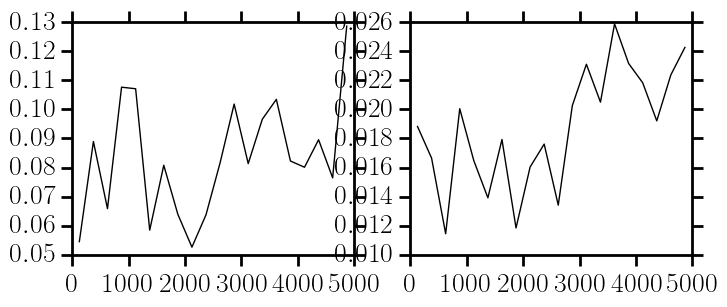

In [125]:
x = params_rand[:, 4]
error = np.abs(phase_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
error_1d_projection_plot(ax1, x, error, error_type='max', nbins=20, c='k')
error_1d_projection_plot(ax2, x, error, error_type='mean', nbins=20, c='k')